## Import Modules

In [85]:
import pandas as pd
import numpy as np
import re
import nltk

## Reading Data

In [86]:
data = pd.read_csv('./data/data.csv')
data.head(1)

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True


In [87]:
# Selecting Required Columns
df = data[['Title', 'Genre', 'Actors', 'Plot', 'Director']].copy()
df.head(2)

,Title,Genre,Actors,Plot,Director
0,The Shawshank Redemption,"Crime, Drama","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,Frank Darabont
1,The Godfather,"Crime, Drama","Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...,Francis Ford Coppola


## Cleaning Data

In [88]:
from collections import Counter
from nltk.corpus import stopwords

def clean_text(text):
  # Lowercase
  text = text.lower()
  # Remvoe Punctuations
  text = re.sub(r'[^\w\s]', ' ', text)
  # Remove Spaces
  text = re.sub(r'\s+', ' ', text)
  # Removing Stopwords
  stop_words = stopwords.words('english')
  stopwords_dict = Counter(stop_words)
  text = ' '.join({word for word in text.split() if word not in stopwords_dict and len(word)>2})
  # Tokenize Word
  text_tokenized = nltk.word_tokenize(text)
  
  return ' '.join(text_tokenized)

In [89]:
# Applying clean_text on genre, plot, actors, directors
df['clean genre'] = df['Genre'].apply(clean_text)
df['clean plot'] = df['Plot'].apply(clean_text)

# For Actors Let's Combine their names before cleaning
df['clean actors'] = df['Actors'].apply(lambda x: x.replace(' ', ''))
df['clean actors'] = df['clean actors'].apply(clean_text)

# Also Let's combine director name
df['clean director'] = df['Director'].apply(lambda x: x.replace(' ', ''))
df['clean director'] = df['clean director'].apply(clean_text)

df.head(2)

,Title,Genre,Actors,Plot,Director,clean genre,clean plot,clean actors,clean director
0,The Shawshank Redemption,"Crime, Drama","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,Frank Darabont,crime drama,eventual men bond finding solace redemption de...,timrobbins bobgunton williamsadler morganfreeman,frankdarabont
1,The Godfather,"Crime, Drama","Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...,Francis Ford Coppola,crime drama,organized clandestine empire patriarch aging d...,richards alpacino marlonbrando jamescaan caste...,francisfordcoppola


## Combining Cleaned Columns

In [90]:
# Combining columns
df['Cleaned_Text'] = df[['clean plot', 'clean genre', 'clean actors', 'clean director']].T.agg(' '.join)
df['Cleaned_Text'][0]

'eventual men bond finding solace redemption decency common number imprisoned two acts years crime drama timrobbins bobgunton williamsadler morganfreeman frankdarabont'

In [91]:
# Updating Dataframe
df_cleaned = df[['Title', 'Cleaned_Text']]
df_cleaned.head(3)

,Title,Cleaned_Text
0,The Shawshank Redemption,eventual men bond finding solace redemption de...
1,The Godfather,organized clandestine empire patriarch aging d...
2,The Godfather: Part II,corleone grip expands early career life michae...


## Visualizing Data

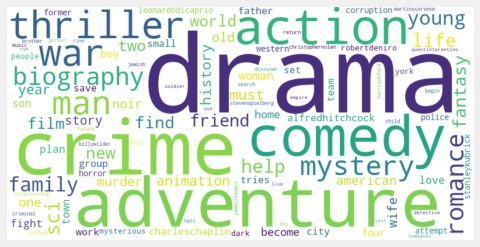

In [92]:
# Cloud Generator
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def cloud(data, column):
  string = (' ').join(list(data[column]))
  wordcloud = WordCloud(max_words=100, background_color='white', width=800, height=400, collocations=False).generate(string)
  plt.figure(figsize=(8, 4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

cloud(df_cleaned, 'Cleaned_Text')


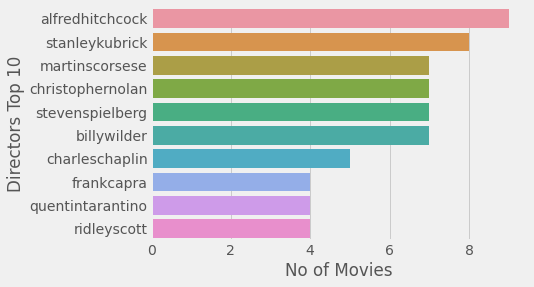

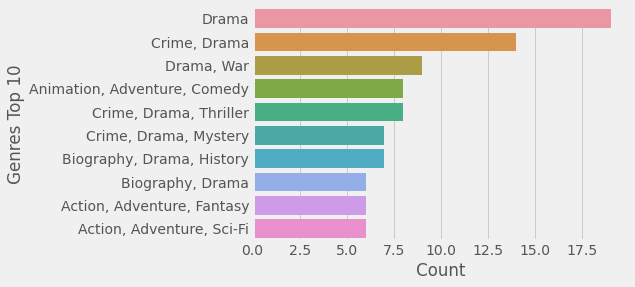

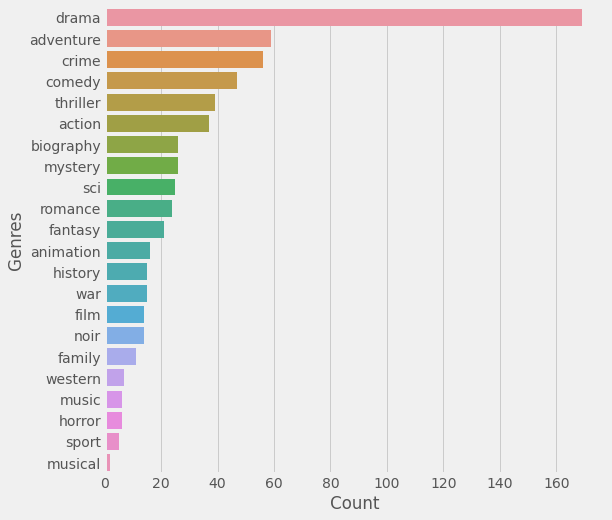

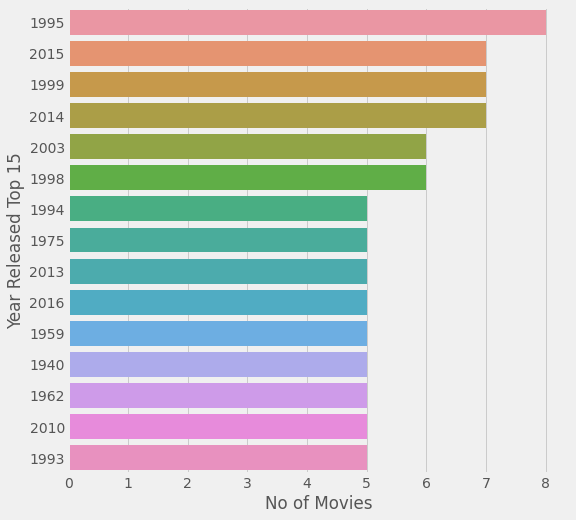

In [93]:
import seaborn as sns
plt.style.use('fivethirtyeight')

# Directors vs No of Movies Plot
sns.countplot(y='clean director', data=df, order=df['clean director'].value_counts().iloc[:10].index)
plt.ylabel('Directors Top 10')
plt.xlabel('No of Movies')
plt.show()

# Genres
sns.countplot(y='Genre', data=df, order=df['Genre'].value_counts().iloc[:10].index)
plt.ylabel('Genres Top 10')
plt.xlabel('Count')
plt.show()

genres = pd.DataFrame([x for item in df['clean genre'].apply(lambda x: x.split(' ')) for x in item], columns=['Genre'])
plt.figure(figsize=(8,8))
sns.countplot(y='Genre', data=genres, order=genres['Genre'].value_counts().index)
plt.ylabel('Genres')
plt.xlabel('Count')
plt.show()

plt.figure(figsize=(8,8))
sns.countplot(y='Year', data=data, order=data['Year'].value_counts().iloc[:15].index)
plt.ylabel('Year Released Top 15')
plt.xlabel('No of Movies')
plt.show()

## Preprocessing

In [94]:
# TfidVectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfid = tfidf.fit_transform(df_cleaned['Cleaned_Text'])

# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfid, tfid)

In [95]:
def Recommender(title):
  idx = df_cleaned[df_cleaned.Title == title].index[0]
  score = pd.Series(cosine_sim[idx]).sort_values(ascending=False)
  top5 = list(score.iloc[0:5].index)
  if top5:
    return df_cleaned['Title'].iloc[top5].reset_index(drop=True)
    
Recommender('Batman Begins')

0             Batman Begins
1           The Dark Knight
2     The Dark Knight Rises
3              The Prestige
4    Spider-Man: Homecoming
Name: Title, dtype: object